<a href="https://colab.research.google.com/github/vedanth-aggarwal/transferlearning_featureextraction_into/blob/main/transferlearning_featureextraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
""" Leveraging a working model's existing architecture and learned patterns for benefit"
# - Leverage existing neural network proven to work
# - Adapt patters to our own data

In [ ]:
!nvidia-smi

Mon Apr 29 04:44:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# 10% of food classes from food101
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2024-04-30 04:42:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.207, 74.125.124.207, 142.250.152.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   174MB/s    in 0.9s    

2024-04-30 04:42:04 (174 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import os

for dirpath, dirnames,filenames in os.walk('10_food_classes_10_percent'):
  print(len(dirnames),len(filenames),dirpath)

2 0 10_food_classes_10_percent
10 0 10_food_classes_10_percent/test
0 250 10_food_classes_10_percent/test/ice_cream
0 250 10_food_classes_10_percent/test/grilled_salmon
0 250 10_food_classes_10_percent/test/ramen
0 250 10_food_classes_10_percent/test/chicken_curry
0 250 10_food_classes_10_percent/test/chicken_wings
0 250 10_food_classes_10_percent/test/steak
0 250 10_food_classes_10_percent/test/pizza
0 250 10_food_classes_10_percent/test/sushi
0 250 10_food_classes_10_percent/test/hamburger
0 250 10_food_classes_10_percent/test/fried_rice
10 0 10_food_classes_10_percent/train
0 75 10_food_classes_10_percent/train/ice_cream
0 75 10_food_classes_10_percent/train/grilled_salmon
0 75 10_food_classes_10_percent/train/ramen
0 75 10_food_classes_10_percent/train/chicken_curry
0 75 10_food_classes_10_percent/train/chicken_wings
0 75 10_food_classes_10_percent/train/steak
0 75 10_food_classes_10_percent/train/pizza
0 75 10_food_classes_10_percent/train/sushi
0 75 10_food_classes_10_percent/tra

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

train_data10 = train_datagen.flow_from_directory(train_dir,batch_size=32,target_size=(224,224),
                                               class_mode = 'categorical',seed=42)
test_data10 = test_datagen.flow_from_directory(test_dir,batch_size=32,target_size=(224,224),
                                               class_mode = 'categorical',seed=42)


# Build a CNN ( Tiny VGG CNN Explainer website)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
# Callbacks are extra func fo after and before training
# tracking experiment with tensorboard callback
# model checkpoint callback
# early stopping callback

In [ ]:
# Create TensorBoard callback ( new one for each model)
import datetime

def create_tensorboard_callback(dir_name,exp_name):
  log_dir = dir_name + '/' + exp_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
  print(f'Saving: {log_dir}')
  return tensorboard_callback

In [ ]:
# Creating models using tensorflow hub
""" We can use layers of models from the hub, access pretrained models """


' We can use layers of models from the hub, access pretrained models '

In [ ]:
# IMAGENET , RESNET, FEATURENET, EFFICIENT NET
# PAPERS WITH CODE

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [ ]:
def create_model(model_url,num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url,trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape=(224,224)+(3,)) # freeze already learned patterns
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation='softmax',name='output_layer')
  ])
  return model


In [ ]:
resnet_model = create_model(resnet_url,train_data10.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

resnet_history = resnet_model.fit(train_data10,
                                  epochs=5,
                                  steps_per_epoch=len(train_data10),
                                  validation_data=test_data10,
                                  validation_steps = len(test_data10),
                                  callbacks=[create_tensorboard_callback("tensorflow_hub","resnet50V2")])

Saving: tensorflow_hub/resnet50V2/20240430-050105
Epoch 1/5
24/24 [==============================] - 15s 472ms/step - loss: 1.9488 - accuracy: 0.3440 - val_loss: 1.2563 - val_accuracy: 0.5972
Epoch 2/5
24/24 [==============================] - 10s 440ms/step - loss: 0.9217 - accuracy: 0.7320 - val_loss: 0.8337 - val_accuracy: 0.7388
Epoch 3/5
24/24 [==============================] - 10s 449ms/step - loss: 0.6228 - accuracy: 0.8227 - val_loss: 0.7462 - val_accuracy: 0.7584
Epoch 4/5
24/24 [==============================] - 10s 415ms/step - loss: 0.4787 - accuracy: 0.8760 - val_loss: 0.7033 - val_accuracy: 0.7720
Epoch 5/5
24/24 [==============================] - 11s 458ms/step - loss: 0.3780 - accuracy: 0.9093 - val_loss: 0.6633 - val_accuracy: 0.7760


In [ ]:
# resnet50* feature extractor

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))

  plt.plot(epochs,loss,label='train loss')
  plt.plot(epochs,val_loss,label='val loss')
  plt.title('loss curve')
  plt.xlabel('epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs,accuracy,label='train acc')
  plt.plot(epochs,val_accuracy,label='val acc')
  plt.title('accuracy curve')
  plt.xlabel('epochs')
  plt.legend()

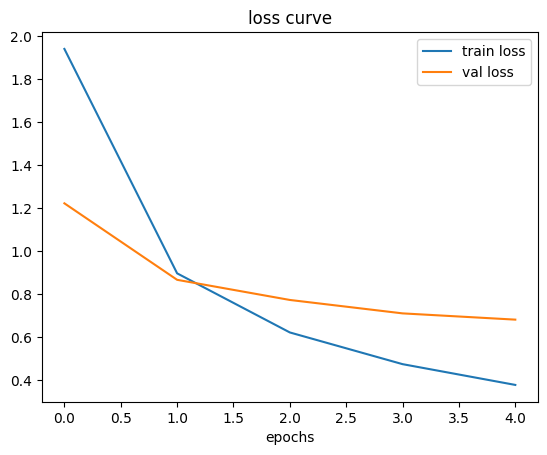

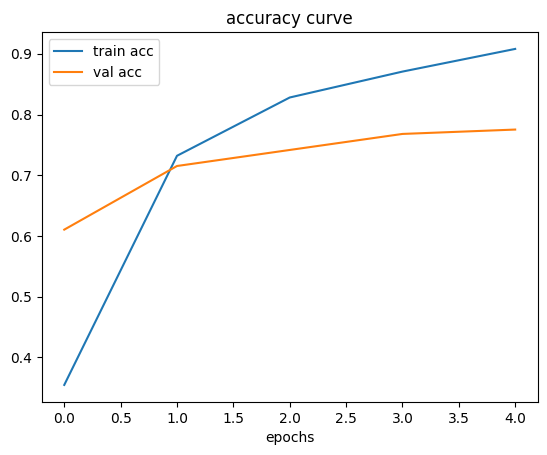

In [ ]:
import matplotlib.pyplot as plt
plot_loss_curves(resnet_history)

In [ ]:
efficientnet_model = create_model(efficientnet_url)

In [ ]:
efficientnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(train_data10,
                                  epochs=5,
                                  steps_per_epoch=len(train_data10),
                                  validation_data=test_data10,
                                  validation_steps = len(test_data10),
                                  callbacks=[create_tensorboard_callback("tensorflow_hub","efficientnetb0")])

Saving: tensorflow_hub/efficientnetb0/20240430-044759
Epoch 1/5
24/24 [==============================] - 14s 469ms/step - loss: 0.4572 - accuracy: 0.8973 - val_loss: 0.5027 - val_accuracy: 0.8728
Epoch 2/5
24/24 [==============================] - 10s 421ms/step - loss: 0.3648 - accuracy: 0.9200 - val_loss: 0.4654 - val_accuracy: 0.8780
Epoch 3/5
24/24 [==============================] - 12s 535ms/step - loss: 0.3108 - accuracy: 0.9413 - val_loss: 0.4445 - val_accuracy: 0.8820
Epoch 4/5
24/24 [==============================] - 10s 429ms/step - loss: 0.2702 - accuracy: 0.9547 - val_loss: 0.4321 - val_accuracy: 0.8780
Epoch 5/5
24/24 [==============================] - 10s 449ms/step - loss: 0.2343 - accuracy: 0.9680 - val_loss: 0.4154 - val_accuracy: 0.8844


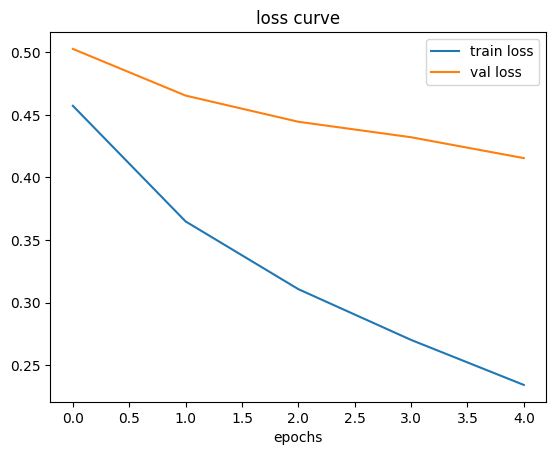

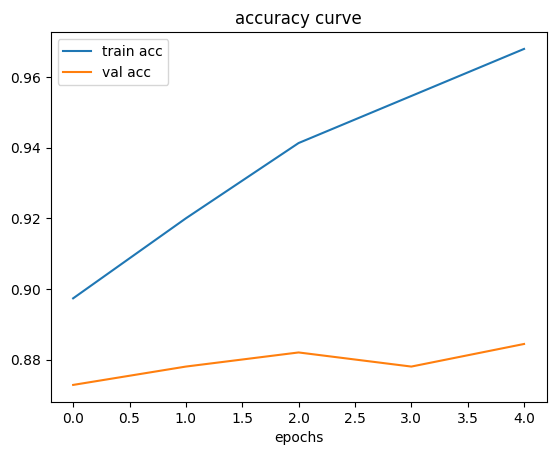

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
"""
As is - use existing model with no changes ( image net on 1000 image net casses)
Feature extraction - use prelearned patterns and adjust output layer ( 10 food classes)
Fine tuning - prelearned patterns and fine tune underlying layers and output

"""

In [ ]:
len(efficientnet_model.layers[0].weights) # no of layers

309

In [ ]:
# Tensorboard - experiments are public

!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficientNetB0 vs ResNet50V2" \
--description "Comparing different TF hub feature extraction models" \
--one_shot

2024-04-30 05:06:27.287231: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 05:06:27.287282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 05:06:27.288508: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-30 05:06:28.291975: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir tensorflow_hub/

<IPython.core.display.Javascript object>

In [ ]:
!tensorboard dev list

2024-04-30 05:10:52.480777: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 05:10:52.480851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 05:10:52.482510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-30 05:10:53.926736: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard.dev Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to

In [ ]:
# wandb weights and biases integrates with tensorflow